# A TUTORIAL ON NEURAL NETWORK REGRESSION USING TENSORFLOW AND KERAS

by Sebastian T. Glavind, June, 2020

# Introduction

In this tutorial, we will consider how to define, train and predict with a feed-forward neural network model using tensorflow and keras. First, we will consider a simple one-input, one-output relation. Second, we will consider how easy it is to extend the model formulation in the number of outputs; including additional inputs follows the same line of reasoning. Third, we will show how to choose the hyperparameters using cross-validation and random search, as well as Bayesian optimization. Note that random search is found to be superior to grid search when the model contains many hyperparameters. The interested reader is referred to the prominent textbook of Goodfellow et al. (2016) for an introduction to neural networks, and Geron (2019) for an excellent guide on their implementation.

We will consider small data sets in the tutorial, so that training can be performed on a standard PC, thus regularization becomes extra important!

***
I. Goodfellow, Y. Bengio, and A. Courville, Deep Learning. MIT Press, 2016, http://www.deeplearningbook.org.

A. Geron, Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems. O’Reilly Media, 2019.
***

# Prelude

In [1]:
import numpy as np
import scipy.stats as ss 
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.preprocessing
%matplotlib inline

In [2]:
# tensorflow 2.1
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import Input, InputLayer, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Single-output Neural network


## Sample data


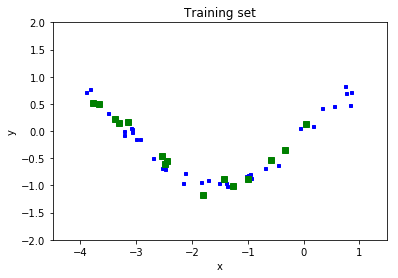

In [3]:
# Noise free/Noisy training data
np.random.seed(42)
nXraw = 50 # no. of training points
std_y = 1e-1 # if noise free set to 1e-4 for numerical stability; corr. var = 1e-16 addition along diagonal
Xraw = np.random.uniform(low=-4, high=1, size=(nXraw,1)).reshape(-1,1) # input
yraw = np.sin(Xraw) + std_y*np.random.normal(size=(nXraw,1)) # output (sin function)

# Split into training and test data
Xtrain, Xtest, ytrain, ytest = sklearn.model_selection.train_test_split(Xraw,yraw, train_size=.7, random_state=1)
nX_tr, mX_tr = Xtrain.shape

# plot
plt.plot(Xtrain, ytrain, 'bs', ms=3);
plt.plot(Xtest, ytest, 'gs', ms=6);
plt.axis([-4.5, 1.5, -2, 2]);
plt.xlabel('x');
plt.ylabel('y');
plt.title('Training set');

### Scaling of inputs according to scale of training data

In [4]:
# Standardize features
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(Xtrain)
sXtrain = scaler.transform(Xtrain)
sXtest = scaler.transform(Xtest)

## NN model

### Model definition

In this section, we will consider a neural network with two hidden layers of 32 units each and regularize the network training using early stopping. Other kinds of regularization are e.g. dropout and batch normalization (commented out below), see e.g. Goodfellow et al. (2016) for a reference on early stopping and dropout.

***
I. Goodfellow, Y. Bengio, and A. Courville, Deep Learning. MIT Press, 2016, http://www.deeplearningbook.org.
***

In [5]:
NN_model = keras.models.Sequential()

# The Input Layer :
NN_model.add(Input(shape=(sXtrain.shape[1])))
# NN_model.add(Flatten(input_shape=[Xtrain.shape[1]]))
# NN_model.add(InputLayer(input_shape=Xtrain.shape[1]))
# NN_model.add(BatchNormalization())

# The Hidden Layers :
for layer in range(2):
        NN_model.add(Dense(32, kernel_initializer='normal',activation='relu'))
#         NN_model.add(Dropout(.5))
#         NN_model.add(BatchNormalization())

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


### Model training

In [6]:
# checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
# checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
# callbacks_list = [checkpoint]
# mcp = ModelCheckpoint("NNR_uni.hd5", save_best_only=True, period=5)
# csv = CSVLogger("NNR_uni.csv")
es = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
lr = ReduceLROnPlateau(patience=10, verbose=1)
callbacks_list = [es, lr]

In [7]:
tf.random.set_seed(123)
history = NN_model.fit(sXtrain, ytrain, epochs=100, batch_size=8, validation_split=0.2, callbacks=callbacks_list)

Train on 28 samples, validate on 7 samples
Epoch 1/100
28/28 [==============================] - 0s 15ms/sample - loss: 0.4552 - mse: 0.4552 - val_loss: 0.2681 - val_mse: 0.2681
Epoch 2/100
28/28 [==============================] - 0s 897us/sample - loss: 0.4515 - mse: 0.4515 - val_loss: 0.2677 - val_mse: 0.2677
Epoch 3/100
28/28 [==============================] - 0s 949us/sample - loss: 0.4491 - mse: 0.4491 - val_loss: 0.2675 - val_mse: 0.2675
Epoch 4/100
28/28 [==============================] - 0s 1ms/sample - loss: 0.4455 - mse: 0.4455 - val_loss: 0.2672 - val_mse: 0.2672
Epoch 5/100
28/28 [==============================] - 0s 944us/sample - loss: 0.4424 - mse: 0.4424 - val_loss: 0.2667 - val_mse: 0.2667
Epoch 6/100
28/28 [==============================] - 0s 1ms/sample - loss: 0.4383 - mse: 0.4383 - val_loss: 0.2660 - val_mse: 0.2660
Epoch 7/100
28/28 [==============================] - 0s 1ms/sample - loss: 0.4344 - mse: 0.4344 - val_loss: 0.2656 - val_mse: 0.2656
Epoch 8/100
28/28 [

Epoch 00060: early stopping


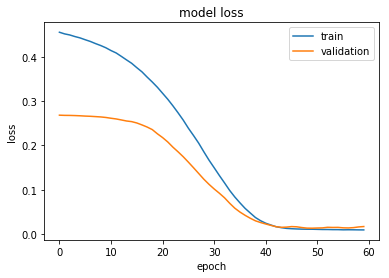

In [8]:
# print(history.history.keys())
# "Loss"
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right');

### Model predictions

In [9]:
print('Training data')
MSE = NN_model.evaluate(sXtrain, ytrain)
VAR = MSE[0]; print('Variance estimate: ', round(VAR,2), ' and True variance: ', round(std_y**2,2))
print('Test data')
NN_model.evaluate(sXtest, ytest)
# predictions
Xpred = np.arange(-5,2,0.05).reshape(-1,1)
sXpred = scaler.transform(Xpred)
model_pred = NN_model.predict(sXpred)

Training data
35/35 [==============================] - 0s 223us/sample - loss: 0.0110 - mse: 0.0110
Variance estimate:  0.01  and True variance:  0.01
Test data
15/15 [==============================] - 0s 131us/sample - loss: 0.0076 - mse: 0.0076


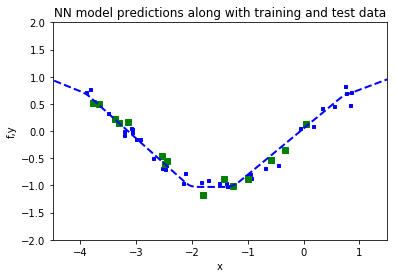

In [10]:
plt.plot(Xtrain, ytrain, 'bs', ms=3)
plt.plot(Xtest, ytest, 'gs', ms=6);
plt.plot(Xpred, model_pred, 'b--', lw=2)
plt.axis([-4.5, 1.5, -2, 2]);
plt.xlabel('x')
plt.ylabel('f,y')
plt.title('NN model predictions along with training and test data');
# plt.show()

# Multi-output Neural network

## Sample data

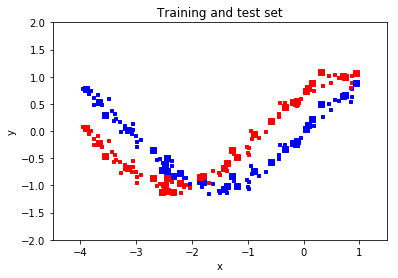

In [11]:
# Noise free/Noisy training data
np.random.seed(42)
nXraw2 = 100 # no. of training points
std_y2 = 1e-1 # if noise free set to 1e-4 for numerical stability; corr. var = 1e-16 addition along diagonal
Xraw2 = np.random.uniform(low=-4, high=1, size=(nXraw2,1)).reshape(-1,1) # input
yraw2 = np.concatenate((np.sin(Xraw2), np.sin(Xraw2+np.pi/4)), axis=1) + std_y2*np.random.normal(size=(nXraw2,1))

Xtrain2, Xtest2, ytrain2, ytest2 = sklearn.model_selection.train_test_split(Xraw2,yraw2, train_size=.7, random_state=1)

# plot
plt.plot(Xtrain2, ytrain2[:,0], 'bs', ms=3);
plt.plot(Xtrain2, ytrain2[:,1], 'rs', ms=3);
plt.plot(Xtest2, ytest2[:,0], 'bs', ms=6);
plt.plot(Xtest2, ytest2[:,1], 'rs', ms=6);
plt.axis([-4.5, 1.5, -2, 2]);
plt.xlabel('x');
plt.ylabel('y');
plt.title('Training and test set');

### Scaling of inputs according to scale of training data

In [12]:
scaler2 = sklearn.preprocessing.StandardScaler()
scaler2.fit(Xtrain2)
sXtrain2 = scaler.transform(Xtrain2)
sXtest2 = scaler.transform(Xtest2)

## NN model

### Model definition

In [13]:
NN_model2 = keras.models.Sequential()

# The Input Layer :
NN_model2.add(Input(shape=(sXtrain2.shape[1])))
# NN_model.add(BatchNormalization())

# The Hidden Layers :
for layer in range(2):
        NN_model2.add(Dense(32, kernel_initializer='normal',activation='relu'))
#         NN_model2.add(Dropout(.5))
#         NN_model.add(BatchNormalization())

# The Output Layer :
NN_model2.add(Dense(ytest2.shape[1], kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model2.compile(loss='mse', optimizer='adam', metrics=['mse'])

NN_model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                64        
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 1,186
Trainable params: 1,186
Non-trainable params: 0
_________________________________________________________________


### Model training

In [14]:
tf.random.set_seed(123)
history2 = NN_model2.fit(sXtrain2, ytrain2, epochs=100, batch_size=8, validation_split=0.2, callbacks=callbacks_list)

Train on 56 samples, validate on 14 samples
Epoch 1/100
56/56 [==============================] - 0s 6ms/sample - loss: 0.4566 - mse: 0.4566 - val_loss: 0.3261 - val_mse: 0.3261
Epoch 2/100
56/56 [==============================] - 0s 769us/sample - loss: 0.4492 - mse: 0.4492 - val_loss: 0.3232 - val_mse: 0.3232
Epoch 3/100
56/56 [==============================] - 0s 666us/sample - loss: 0.4410 - mse: 0.4410 - val_loss: 0.3189 - val_mse: 0.3189
Epoch 4/100
56/56 [==============================] - 0s 646us/sample - loss: 0.4307 - mse: 0.4307 - val_loss: 0.3128 - val_mse: 0.3128
Epoch 5/100
56/56 [==============================] - 0s 642us/sample - loss: 0.4201 - mse: 0.4201 - val_loss: 0.3064 - val_mse: 0.3064
Epoch 6/100
56/56 [==============================] - 0s 640us/sample - loss: 0.4038 - mse: 0.4038 - val_loss: 0.2979 - val_mse: 0.2979
Epoch 7/100
56/56 [==============================] - 0s 661us/sample - loss: 0.3880 - mse: 0.3880 - val_loss: 0.2896 - val_mse: 0.2896
Epoch 8/100
5

Epoch 61/100
56/56 [==============================] - 0s 645us/sample - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0221 - val_mse: 0.0221
Epoch 62/100
56/56 [==============================] - 0s 667us/sample - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 63/100
56/56 [==============================] - 0s 745us/sample - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 64/100
56/56 [==============================] - 0s 695us/sample - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0217 - val_mse: 0.0217
Epoch 65/100
56/56 [==============================] - 0s 689us/sample - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0213 - val_mse: 0.0213
Epoch 66/100
56/56 [==============================] - 0s 705us/sample - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 67/100
56/56 [==============================] - 0s 561us/sample - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0210 - val_mse: 0.0210
Epoch 68/100
56/56 [============================

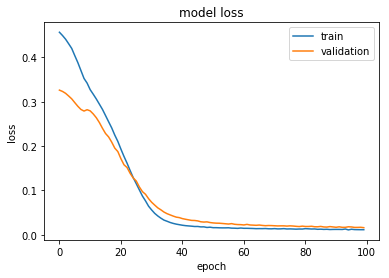

In [15]:
# print(history.history.keys())
# "Loss"
plt.figure()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right');

### Model predictions

In [16]:
print('Training data')
NN_model2.evaluate(sXtrain2, ytrain2)
print('Test data')
NN_model2.evaluate(sXtest2, ytest2)
# predictions
Xpred2 = np.arange(-5,2,0.1).reshape(-1,1)
sXpred2 = scaler.transform(Xpred2)
model_pred2 = NN_model2.predict(sXpred2)

Training data
70/70 [==============================] - 0s 85us/sample - loss: 0.0120 - mse: 0.0120
Test data
30/30 [==============================] - 0s 106us/sample - loss: 0.0128 - mse: 0.0128


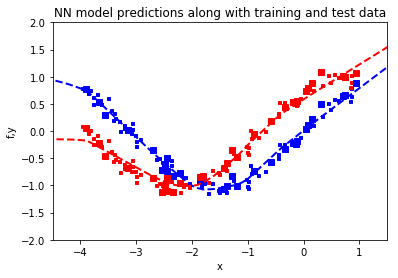

In [17]:
plt.figure()
plt.plot(Xtrain2, ytrain2[:,0], 'bs', ms=3);
plt.plot(Xtrain2, ytrain2[:,1], 'rs', ms=3);
plt.plot(Xtest2, ytest2[:,0], 'bs', ms=6);
plt.plot(Xtest2, ytest2[:,1], 'rs', ms=6);
plt.plot(Xpred2, model_pred2[:,0], 'b--', lw=2)
plt.plot(Xpred2, model_pred2[:,1], 'r--', lw=2)
plt.axis([-4.5, 1.5, -2, 2]);
plt.xlabel('x')
plt.ylabel('f,y')
plt.title('NN model predictions along with training and test data');
# plt.show()

# Hyperparameter optimization

It gets tedious to find an "optimal" combination of the hyperparameters by hand, so in this section, we will explore how we can automate this process.

## Random search

In this section, we will use the random search implementation `RandomizedSearchCV` of the `sklearn` package to select a setting for the model hyperparameters, which we will take to be the number of hidden layers and neurons.

In [18]:
from sklearn.model_selection import RandomizedSearchCV

First, we define a model builder function for `RandomizedSearchCV`;

In [19]:
def model_opt(n_hidden=1, n_units=32, input_shape=[1]):
    model = keras.models.Sequential()

    # The Input Layer :
    model.add(InputLayer(input_shape=input_shape))
#     NN_model.add(BatchNormalization())

    # The Hidden Layers :
    for layer in range(n_hidden):
        model.add(Dense(n_units, kernel_initializer='normal',activation='relu'))
#         model.add(Dropout(.5))
#         NN_model.add(BatchNormalization())

    # The Output Layer :
    model.add(Dense(2, kernel_initializer='normal',activation='linear'))

    # Compile the network :
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    return(model)

Second, we wrap for use with `sklearn` using the `KerasRegressor` function, define the search space, and perform the optimization. Note that this takes a little time consuming even this small toy example, and thus the optimization is pre-run, saved and loaded below (uncomment the content of the following two cells to re-run the optimization). Note that the splitting of the training data in this case, i.e. `validation_split`, only accounts for early-stopping, as the validation error in `RandomizedSearchCV` is evaluated using k-fold cross-validation.

In [20]:
# keras_reg = keras.wrappers.scikit_learn.KerasRegressor(model_opt)

# hyper_param = {'n_hidden': [1,2,3,4],
#                'n_units': np.power(2, np.arange(3,7))
#               }

# rsCV = RandomizedSearchCV(keras_reg, hyper_param, n_iter=10, cv=3)
# rsCV.fit(sXtrain2, ytrain2, epochs=100, batch_size=8, validation_split = 0.2, callbacks=callbacks_list);

In [21]:
# print(rsCV.best_params_)
# optModel2rs = rsCV.best_estimator_.model
# optModel2rs.save('NNreg_optModel2rs.h5')  # creates a HDF5 file 'my_model.h5'

In [22]:
optModel2rs = keras.models.load_model('NNreg_optModel2rs.h5')
optModel2rs.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 64)                128       
_________________________________________________________________
dense_112 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_113 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_114 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_115 (Dense)            (None, 2)                 130       
Total params: 12,738
Trainable params: 12,738
Non-trainable params: 0
_________________________________________________________________


### Model predictions

In [23]:
print('Training data')
optModel2rs.evaluate(sXtrain2, ytrain2)
print('Test data')
optModel2rs.evaluate(sXtest2, ytest2)
optModel_pred2rs = optModel2rs.predict(sXpred2)

Training data
70/70 [==============================] - 0s 1ms/sample - loss: 0.0095 - mse: 0.0095
Test data
30/30 [==============================] - 0s 115us/sample - loss: 0.0116 - mse: 0.0116


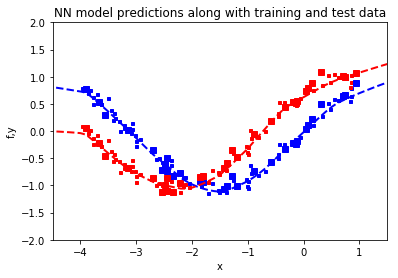

In [24]:
plt.figure()
plt.plot(Xtrain2, ytrain2[:,0], 'bs', ms=3);
plt.plot(Xtrain2, ytrain2[:,1], 'rs', ms=3);
plt.plot(Xtest2, ytest2[:,0], 'bs', ms=6);
plt.plot(Xtest2, ytest2[:,1], 'rs', ms=6);
plt.plot(Xpred2, optModel_pred2rs[:,0], 'b--', lw=2)
plt.plot(Xpred2, optModel_pred2rs[:,1], 'r--', lw=2)
plt.axis([-4.5, 1.5, -2, 2]);
plt.xlabel('x')
plt.ylabel('f,y')
plt.title('NN model predictions along with training and test data');
# plt.show()

This is already pretty good, but if we were to continue this iterative process, we would try out a smaller range of possible network architectures around the current best network, e.g. NNs with four hidden layer and range(32,128,4) neurons.

## Bayesian optimization

In this section, we will use the Bayesian optimization implementation `BayesSearchCV` of the `skopt` package to select a setting for the model hyperparameters, which we will take to be the number of hidden layers and neurons.

COMMING SOON